# LVC GW Targets

Generate a target list of host galaxies given the 50% and 90% credible localization regions of a GW alert.

In [1]:
from astropy.io import fits
from astropy.table import Table

import healpy as hp

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from gw_skymap import compute_quantiles, compute_contours, plot_gwmap

from desitarget.io import read_targets_in_hp, read_targets_in_box, read_targets_in_cap, check_hp_target_dir
from desitarget.targetmask import desi_mask, bgs_mask

## Read GW LALInference Map

Extract localization PDF for a GW event and plot it using the DESI footprint.

Data can be downloaded from the [LVC GraceDB public alert page](https://gracedb.ligo.org/).

In [2]:
fits_file = 'GW190412_skymap.fits.gz'

# Read metadata.
hdus = fits.open(fits_file)
header = hdus[1].header

# instruments = header['INSTRUME']
distmean = header['DISTMEAN']
diststd = header['DISTSTD']
origin = header['ORIGIN']
date = header['DATE']

gwmap = hp.read_map(fits_file)
npix = len(gwmap)
nside = hp.npix2nside(npix)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  

In [3]:
# Compute GW quantiles.
levels = [0.50, 0.90]
lev50, lev90 = compute_quantiles(levels, gwmap)
print(levels, lev50, lev90)

# # Compute GW quantiles for degraded map.
# gwmap64 = hp.pixelfunc.ud_grade(gwmap, 64) #reduce nside to make it faster
# gwmap64 = gwmap64/np.sum(gwmap64)
# lev50, lev90 = compute_quantiles(levels, gwmap64)
# print(levels, lev50, lev90)

[0.5, 0.9] 0.0002977923419504475 5.45145832371135e-05


/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 45 deg 0.00'.
  warnings.warn(


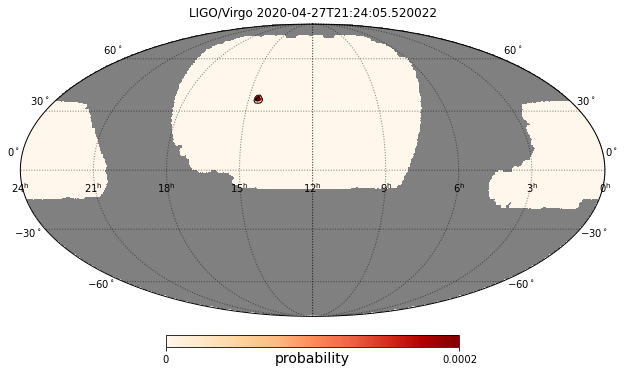

In [4]:
fig = plot_gwmap('GW190412_skymap.fits.gz', levels=[0.5, 0.9])
fig.savefig('gw_skymap.png', dpi=100)

In [5]:
maxpix = np.argmax(gwmap)
ra_c, dec_c = hp.pix2ang(nside, maxpix, lonlat=True)
print(ra_c, dec_c)

218.49609375 36.469945487867896


## Load DR8 Targets

Using the code from the [DESI target example notebook](https://github.com/qmxp55/desi_uk_meeting_2019/blob/master/desitarget_local_example.ipynb) created by Omar Macias, extract the targets within a box surrounding the 90% C.I.

In [6]:
# pixids = hp.ring2nest(64, np.arange(len(gwmap64)))
# pix50 = pixids[gwmap64 > lev50]
# pix90 = pixids[gwmap64 > lev90]

pixids = hp.ring2nest(nside, np.arange(npix))
pix50 = pixids[gwmap > lev50]
pix90 = pixids[gwmap > lev90]

In [7]:
# Load sample of resolved DR8 target catalog using HEALPixels above threshold in the GW map.
hpdirname = '/global/project/projectdirs/desi/target/catalogs/dr9m/0.42.0/targets/main/resolve/dark'
targ90 = Table(read_targets_in_hp(hpdirname, nside=nside, pixlist=pix90))

In [8]:
len(targ90)

43707

In [9]:
bgs_mask_bits = '|'.join([_ for _ in bgs_mask.names() if 'BGS' in _])
bgs_mask_bits 

'BGS_FAINT|BGS_BRIGHT|BGS_WISE|BGS_FAINT_HIP|BGS_FAINT_NORTH|BGS_BRIGHT_NORTH|BGS_WISE_NORTH|BGS_FAINT_SOUTH|BGS_BRIGHT_SOUTH|BGS_WISE_SOUTH'

### Select Targets

Identify targets within the 50% and 90% contours, and apply a basic cut on bright BGS objects.

In [10]:
bgs_targets = (targ90['BGS_TARGET'] & bgs_mask.mask(bgs_mask_bits)) != 0
ra90, dec90 = [targ90[_][bgs_targets] for _ in ['RA', 'DEC']]

rmag = 22.5 - 2.5*np.log10(targ90['FLUX_R'][bgs_targets])
rthr = np.max(rmag)
print('{:8d} targets in 90% C.I. with rmag > {:g}'.format(len(ra90), rthr))

    6845 targets in 90% C.I. with rmag > 20.0333


### Plot the Targets

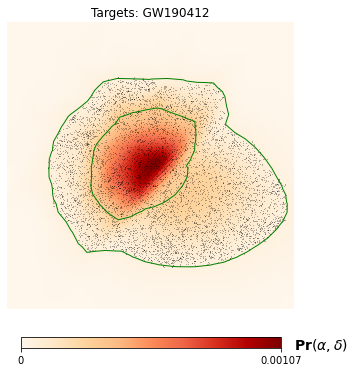

In [11]:
# fig = plt.figure(1, figsize=(4,6))

hp.cartview(gwmap, fig=1, cmap='OrRd',
            lonra=[ra_c-360-3,ra_c-360+3],
            latra=[dec_c-3,dec_c+3],
            min=0, max=np.max(gwmap),
            title='Targets: GW190412', unit=r'Pr$(\alpha,\delta)$', flip='astro')
# hp.projplot(ra50, dec50, 'k,', alpha=0.1, lonlat=True);
hp.projplot(ra90, dec90, 'k,', alpha=0.3, lonlat=True);

# Compute GW contours for degraded map.
# gwmap64 = hp.pixelfunc.ud_grade(gwmap, 64) #reduce nside to make it faster
# gwmap64 = gwmap64/np.sum(gwmap64)
# ra_contour, dec_contour = compute_contours(levels, gwmap64)
gwmap256 = hp.pixelfunc.ud_grade(gwmap, 256) #reduce nside to make it faster
gwmap256 = gwmap256/np.sum(gwmap256)
ra_contour, dec_contour = compute_contours(levels, gwmap256)
for i, (rc, dc) in enumerate(zip(ra_contour, dec_contour)):
    hp.projplot(rc, dc, lonlat=True, linewidth=1, c='g')
    
# fig = plt.gcf()
# fig.savefig('targlist.png', dpi=150)

In [12]:
targ90[bgs_targets]

RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,RA,RA_IVAR,DEC,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_EPOCH,WISEMASK_W1,WISEMASK_W2,MASKBITS,LC_FLUX_W1 [15],LC_FLUX_W2 [15],LC_FLUX_IVAR_W1 [15],LC_FLUX_IVAR_W2 [15],LC_NOBS_W1 [15],LC_NOBS_W2 [15],LC_MJD_W1 [15],LC_MJD_W2 [15],SHAPE_R,SHAPE_E1,SHAPE_E2,SHAPE_R_IVAR,SHAPE_E1_IVAR,SHAPE_E2_IVAR,SERSIC,SERSIC_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL
int16,int32,str8,int32,str4,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,int16,int16,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,int8,float32,float32,float32,float32,float32,float32,str1,int64,int64,int64,int64,float64,int64,int64,int64,int64
9011,518397,2182p345,860,DEV,218.1699836743717,633334300000.0,34.433080178471485,608366170000.0,48245.59 .. 57596.863,0.016268395,2.8043888,14.504528,40.864048,172.55283,26.094538,30.327105,0.95298344,0.9680807,0.9820183,0.13260134,0.028162804,0.01441166,0.021713337,0.011349912,0.010056974,0.99984515,0.9999064,0.969097,3,2,4,574.6361,172.70712,141.31113,427.23212,100.3614,84.6414,85.71947,54.114746,77.98493,-4067.955,1.9244274,0.69754374,0.0022153335,2.9736048e-05,0.9972468,0.99830824,0.999639,0.9998637,0,0,0,0.9163635,4.7395067,13.3527565,0.91666865,4.740119,13.353221,0.0,0,0,0,94.92181 .. 76.428825,55.55733 .. 57.851334,0.28047988 .. 0.24912429,0.07538556 .. 0.040902562,15 .. 13,15 .. 13,55206.950491485 .. 58654.10484722,55206.950491485 .. 58654.10484722,1.1446445,0.077097304,0.08414311,10526.081,14483.647,16065.745,4.0,0.0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,N,39632971426169692,1152921504606847233,257,0,0.8725046155123667,7,3200,1,9150
9011,518397,2182p345,1000,REX,218.1801838530434,118534720000.0,34.41308400024132,124077860000.0,15957.706 .. 0.0,0.016754916,9.56411,14.964383,19.468248,131.0332,23.670023,20.634945,0.95161194,0.967142,0.98148555,0.0074101514,0.0033557245,0.0071823816,0.0060963584,0.0026935278,0.0025930868,0.9986627,0.99945956,0.9993637,3,2,3,574.6361,172.70712,118.93787,427.23212,100.3614,67.40129,11.98788,12.728367,31.438059,-988.0943,3.6401455,0.94778764,0.0024317305,3.1463725e-05,0.99716455,0.9982577,0.9996282,0.9998596,0,0,0,2.1271286,3.3281891,4.329882,2.127143,3.328207,4.329933,0.0,0,0,0,10.763387 .. 11.376141,9.858543 .. 21.255054,0.32291836 .. 0.2945569,0.08516799 .. 0.043207992,15 .. 13,15 .. 13,55206.950491485 .. 58654.10484722,55206.950491485 .. 58654.10484722,1.2251387,0.0,0.0,11433.064,0.0,0.0

In [14]:
targ90[bgs_targets].write('GW190412_BGS_targets_dr9m_0.42.0_dark.fits', format='fits', overwrite=True)

In [15]:
def angle_to_180(angle):
    """Normalize longitude angle between -180 and 180."""
    a = angle
    while a < -180:
        a += 360
    while a > 180:
        a -= 360
    return a

xmin = np.round(ra_c - 3)
xmax = np.round(ra_c + 3)
# xmin = angle_to_180(np.round(ra_c - 5))
# xmax = angle_to_180(np.round(ra_c + 5))
if xmax < xmin:
    xmin, xmax = xmax, xmin
cxmin, cxmax = xmin, xmax
frot = 0.
if xmax > 90 and xmin < -90:
    frot, cxmin, cmax = 180., xmax-180., xmax+180.
ymin = np.round(dec_c - 3)
ymax = np.round(dec_c + 3)

cxmin, cxmax, ymin, ymax

faspect = np.abs(cxmax - cxmin)/np.abs(ymax-ymin)
fysize = 4
figsize = (fysize*faspect+2, fysize+2.75)

tfig   = plt.figure(num=2,figsize=figsize)
rotimg = hp.cartview(gwmap, fig=2,coord='C', title="", cbar=False, flip='astro',
                     lonra=[cxmin,cxmax], latra=[ymin,ymax], rot=frot,
                     notext=True, xsize=1000,
                     return_projected_map=True)
plt.close(tfig)

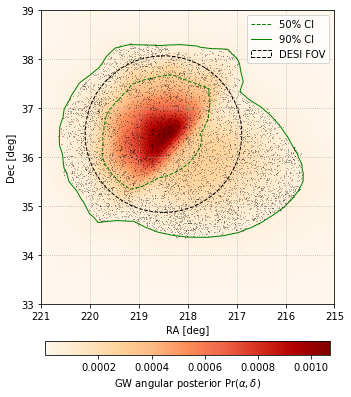

In [16]:
fig, ax = plt.subplots(1,1, num=1, figsize=figsize)
img = ax.imshow(rotimg, extent=[cxmax, cxmin, ymin, ymax],
                origin='lower', cmap='OrRd')

for i, (rc, dc, lstyle, clev) in enumerate(zip(ra_contour, dec_contour, ['--', '-'], ['50', '90'])):
    p = ax.plot(rc, dc, 'g-', ls=lstyle, lw=1, label='{}% CI'.format(clev))

ratarg, dectarg = ra90, dec90
ratarg[ratarg < 0] += 360

ax.plot(ratarg, dectarg, 'k,', alpha=0.3)
ax.set(xlim=(cxmax, cxmin),
       xlabel='RA [deg]',
       ylabel='Dec [deg]')
ax.grid(ls=':')

circ = plt.Circle((ra_c, dec_c), radius=1.6, fc='None', ec='k', ls='--')
ax.add_artist(circ)

_h, _l = ax.get_legend_handles_labels()
_h.append(circ)
_l.append('DESI FOV')

ax.legend(handles=_h, labels=_l)

cb = fig.colorbar(img, orientation='horizontal', shrink=0.85, fraction=0.1,
                  pad=0.1, ax=ax)
cb.set_label(r'GW angular posterior Pr$(\alpha,\delta)$')
fig.savefig('targlist.png')